# 3. Calibration Curves

This notebook focuses on the assessment and visualization of calibration curves for binary classification models. Calibration curves are a useful tool for evaluating the reliability and calibration of probabilistic predictions generated by a model.

#### Packages and Data

First, the necessary packages are imported, including NumPy, pandas, and matplotlib for data manipulation and visualization. The `calibration_curve` function from scikit-learn is imported for generating calibration curves, and `LogisticRegression` and `XGBClassifier` models are imported for demonstration purposes. The `StratifiedKFold` class is used for stratified k-fold cross-validation, and the `SMOTE` algorithm from imbalanced-learn is imported for optional oversampling.

Next, the data is loaded into a pandas DataFrame from a specified directory. Various preprocessing steps are performed on the data, including dropping irrelevant columns, converting data types, and handling missing values.

#### Calibration Assessment

The `assess_calibration` function is defined to assess the calibration of a binary classification model using stratified k-fold cross-validation. It takes as input the features (`X`), the target variable (`y`), the model to be trained and evaluated, the number of splits for cross-validation, and an optional flag for SMOTE oversampling. The function returns the model probability and fraction of positive class results for each run.

The `get_calibration_curve` function is also defined to generate a calibration curve plot based on the model probability and fraction positive results from k-fold cross-validation. It takes the model probability and fraction positive DataFrames as inputs, along with the number of splits used in k-fold cross-validation. The function returns the generated calibration curve plot.

#### Model Evaluation

The notebook proceeds to evaluate the calibration of two different models: a simple logistic regression model and a more advanced XGBoost model.

For the logistic regression model, both the simple model and the SMOTE-oversampled model are evaluated. The model is trained and assessed using the `assess_calibration` function, and the calibration curves are plotted using the `get_calibration_curve` function.

Next, the XGBoost model is evaluated in a similar manner. The more complex model is trained and assessed with and without SMOTE oversampling. The calibration curves are generated and plotted using the previously defined functions.

This notebook provides a step-by-step guide to assess and visualize calibration curves for binary classification models, allowing for the evaluation of model reliability and calibration.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.impute import KNNImputer
import pickle
import seaborn as sns

## Load data

In [2]:
#df = pd.read_csv('../../results/probability_results/during_hypo_3.9mmol_probas.csv')
#df = pd.read_csv('../../results/probability_results/during_hypo_3.9mmol_probas_dexip.csv')
df = pd.read_csv('../../results/probability_results/xgb_two.csv')

FileNotFoundError: [Errno 2] No such file or directory: '../../results/probability_results/xgb_two.csv'

## Heatmap calibration

In [ ]:
df['split_lr_two']= np.nan
df.loc[df['probas_xgb_two']<=0.05, 'split_lr_two'] = 'green'
df.loc[df['probas_xgb_two']>0.05, 'split_lr_two'] = 'amber'
df.loc[df['probas_xgb_two']>0.2, 'split_lr_two'] = 'red'

In [ ]:
df[df['split_lr_two']=='green']['y'].value_counts()

False    7847
True      143
Name: y, dtype: int64

In [ ]:
df.split_lr_two.value_counts()

green    7990
amber    5478
red      1479
Name: split_lr_two, dtype: int64

In [ ]:
df[df['split_lr_two']=='green'].y.mean()

0.017897371714643305

In [ ]:
df.y

0        False
1        False
2        False
3        False
4        False
         ...  
14942     True
14943    False
14944    False
14945     True
14946    False
Name: y, Length: 14947, dtype: bool

In [ ]:
def calibrate_heatmap(df, label):    
    results = []
    for i in df.probas_xgb_ts_fold.unique():
        sub_df = df[df.probas_xgb_ts_fold==i]
        green_ratio = sub_df[sub_df['split_lr_two']=='green'].y.mean()
        amber_ratio = sub_df[sub_df['split_lr_two']=='amber'].y.mean()
        red_ratio = sub_df[sub_df['split_lr_two']=='red'].y.mean()
        results.append([label, green_ratio, amber_ratio, red_ratio])
    return results

In [ ]:
all_results = []

In [ ]:
all_results = all_results + calibrate_heatmap(df, 'all')

In [ ]:
subgroup_test = pd.DataFrame(all_results, columns=['subgroup', 'Green (<5%)', 'Amber (5-20%)', 'Red (>20%)'])

In [ ]:
subgroup_test[['Green (<5%)', 'Amber (5-20%)', 'Red (>20%)']] = subgroup_test[['Green (<5%)', 'Amber (5-20%)', 'Red (>20%)']] *100

In [ ]:
subgroup_test

,subgroup,Green (<5%),Amber (5-20%),Red (>20%)
0,all,2.045728,11.439842,47.133758
1,all,1.481481,12.867647,44.285714
2,all,1.576873,11.694915,43.750000
3,all,1.524778,12.212389,40.140845
4,all,1.587302,12.284069,38.064516
5,all,2.716688,8.880995,43.396226
6,all,1.730532,12.087912,43.571429
7,all,1.282051,12.318841,44.785276
8,all,2.319902,12.500000,37.410072
9,all,1.622971,9.205776,47.142857


In [ ]:
def calculate_confidence_intervals(df, metrics):
    results = pd.DataFrame()
    for met in metrics:
        avg = df[met].mean()
        format_avg = format(avg, '.1f')
        interval = 1.96*df[met].std()/np.sqrt(10)
        ci_high = format((avg + interval), '.1f')
        ci_low = format((avg - interval), '.1f')
        results = results.append(pd.DataFrame([[met,  f'{format_avg} (95% CI {ci_low}, {ci_high})']], columns=['metric', 'value']))
    return results

In [ ]:
ci_results = calculate_confidence_intervals(subgroup_test, ['Green (<5%)', 'Amber (5-20%)', 'Red (>20%)'])
ci_results.columns = ["Predicted risk category", "Observed rate of hypoglycemia (%)"]

In [ ]:
subgroup_test = subgroup_test.melt(id_vars=['subgroup'])

In [ ]:
subgroup_test

,subgroup,variable,value
0,all,Green (<5%),2.045728
1,all,Green (<5%),1.481481
2,all,Green (<5%),1.576873
3,all,Green (<5%),1.524778
4,all,Green (<5%),1.587302
5,all,Green (<5%),2.716688
6,all,Green (<5%),1.730532
7,all,Green (<5%),1.282051
8,all,Green (<5%),2.319902
9,all,Green (<5%),1.622971


In [ ]:

palette_dict = {
    'Green (<5%)': 'green',
    'Amber (5-20%)': 'orange',
    'Red (>20%)': 'red'  # Add more colors if you have more subgroups
}

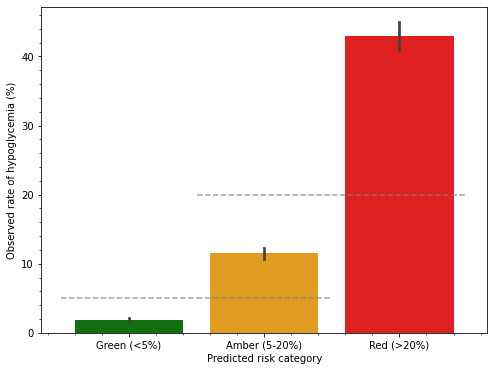

In [ ]:
plt.figure(figsize=(8, 6))

ax = sns.barplot(subgroup_test, x='variable', y='value', errorbar="ci", palette=palette_dict)

# Define the y-values for each bar's lines
lines = [[5], [5, 20], [20]]

# Determine the width of each shaded region based on tick positions
ticks = ax.get_xticks()
region_width = ticks[1] - ticks[0]

# Draw the lines, centered around each tick
for i, (tick, y_values) in enumerate(zip(ticks, lines)):
    start_x = tick - region_width/2
    end_x = tick + region_width/2
    for y in y_values:
        ax.plot([start_x, end_x], [y, y], color='grey', linestyle='--', alpha=0.7)
ax.set_xlabel("Predicted risk category")
ax.set_ylabel("Observed rate of hypoglycemia (%)")

ax.minorticks_on()
#ax.yaxis.grid(True, linestyle='--', linewidth=0.5)
#plt.show()

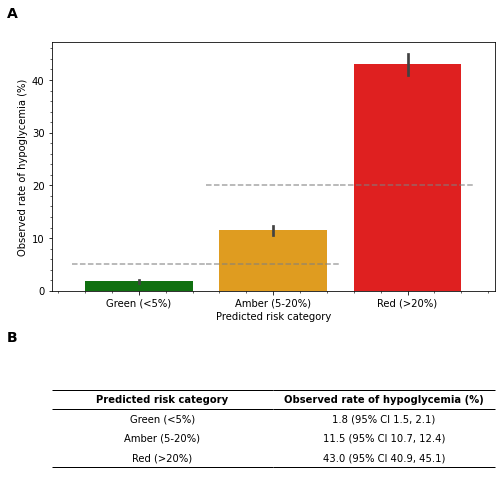

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

# Sample ci_results dataframe (Replace with your actual dataframe)
# ci_results = pd.DataFrame({
#     'Predicted risk category': ["Green (<5%)", "Amber (5-20%)", "Red (>20%)"],
#     'Observed rate of hypoglycemia (%)': ["1.8 (1.5, 2.1)", "11.6 (10.4, 12.7)", "42.7 (40.5, 45.0)"]
# })

# Create gridspec layout
fig = plt.figure(figsize=(7, 7))
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])

# Create main ax for the barplot
ax = plt.subplot(gs[0])

# Your barplot drawing code...
sns.barplot(subgroup_test, x='variable', y='value', errorbar="ci", palette=palette_dict, ax=ax)
# Define the y-values for each bar's lines
lines = [[5], [5, 20], [20]]

# Determine the width of each shaded region based on tick positions
ticks = ax.get_xticks()
region_width = ticks[1] - ticks[0]

# Draw the lines, centered around each tick
for i, (tick, y_values) in enumerate(zip(ticks, lines)):
    start_x = tick - region_width/2
    end_x = tick + region_width/2
    for y in y_values:
        ax.plot([start_x, end_x], [y, y], color='grey', linestyle='--', alpha=0.7)
ax.set_xlabel("Predicted risk category")
ax.set_ylabel("Observed rate of hypoglycemia (%)")

ax.minorticks_on()

# Label as "A"
ax.text(-0.1, 1.1, 'A', transform=ax.transAxes, size=14, weight='bold')

# Create ax for the table beneath the plot
ax_table = plt.subplot(gs[1])

# Extracting data from your dataframe
columns = list(ci_results.columns)
data = ci_results.values.tolist()

# Add table
ax_table.axis('off')
table = ax_table.table(cellText=data, colLabels=columns, loc='center')

# Adjust the table properties if needed
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)  # Adjust the scale values as needed
# Bold the header and the row labels
for (i, j), cell in table.get_celld().items():
    cell.set_text_props(ha='center', va='center')
    if i == 0 or j == -1:
        cell.set_text_props(fontweight='bold')

# Manually setting the borders
for i in range(len(columns)):
    table[0,i].visible_edges = 'B'  # header row
    table[0,i].visible_edges = 'T'  # header row
    table[1,i].visible_edges = 'T'  # header row
    table[2,i].visible_edges = ''  # bottom row
    table[3,i].visible_edges = 'B'  # bottom row

# Label as "B"
ax_table.text(-0.1, 1.2, 'B', transform=ax_table.transAxes, size=14, weight='bold')

plt.tight_layout()
plt.savefig('../../results/figs/suppl_fig_5.pdf')

## All features

In [ ]:
def assess_calibration(df, col_y, col_probas, col_fold):
    """
    Assesses the calibration of a binary classification model using stratified k-fold cross-validation.

    Args:
        X (pd.DataFrame): The input features.
        y (pd.Series): The target variable.
        model: The machine learning model to be trained and evaluated.
        number_of_splits (int): The number of splits for stratified k-fold cross-validation.
        smote (bool, optional): Whether to use SMOTE for oversampling the minority class. Defaults to False.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: The model probability and fraction of positive class results for each run.
    """

    # Define bins
    number_of_bins = 15

    # Set up results DataFrames (to get results from each run)
    results_model_probability = []
    results_fraction_positive = []

    # Loop through the k-fold splits
    loop_counter = 0
    for i in range(0, 10):    
        sub_df = df.loc[df[col_fold]==i]   
        observed =  sub_df[col_y]
        probas = sub_df[col_probas]
        # Get calibration curve (use quantile to make sure all bins exist)
        fraction_pos, model_prob = calibration_curve(
            observed, probas,
           # n_bins=number_of_bins,
            strategy='quantile')    

        # record run results
        results_model_probability.append(model_prob)
        results_fraction_positive.append(fraction_pos)
        
        # Increment loop counter
        loop_counter += 1
        
    # Convert results to DataFrame
    results_model_probability = pd.DataFrame(results_model_probability)
    results_fraction_positive = pd.DataFrame(results_fraction_positive)

    return results_model_probability, results_fraction_positive

In [ ]:
def get_calibration_curve(results_model_probability, results_fraction_positive, number_of_splits, height, ax): 
        """
        Generates a calibration curve plot based on the model probability and fraction positive results from k-fold cross-validation.

        Args:
        results_model_probability (pd.DataFrame): The model probability results for each run.
        results_fraction_positive (pd.DataFrame): The fraction of positive class results for each run.
        number_of_splits (int): The number of splits used in k-fold cross-validation.

        Returns:
        matplotlib.figure.Figure: The generated calibration curve plot.
        """

        # Add individual k-fold runs
        for run in range(number_of_splits):
                ax.plot(results_model_probability.loc[run],
                        results_fraction_positive.loc[run],
                        linestyle='--',
                        linewidth=0.75,
                        color='0.5')

        # Add mean
        ax.plot(results_model_probability.mean(axis=0),
                results_fraction_positive.mean(axis=0),
                linestyle='-',
                linewidth=2,
                color='darkorange',
                label='Mean calibration')

        # Add diagonal
        ax.plot([0, height], [0, height],
                linestyle='--',
                label='Perfect calibration')

        ax.set_xlabel('Model predicted probability hypoglycemia')
        ax.set_ylabel('Observed rate of hypoglycemia')

        #ax.set_title('Reliability plot')

        ax.grid()
        #ax.legend()

        return ax


In [ ]:
ts_results_model_probability, ts_results_fraction_positive = assess_calibration(df, 'y', 'probas_xgb_ts', 'probas_xgb_ts_fold')

In [ ]:
two_results_model_probability, two_results_fraction_positive = assess_calibration(df, 'y', 'probas_xgb_two', 'probas_xgb_two_fold')

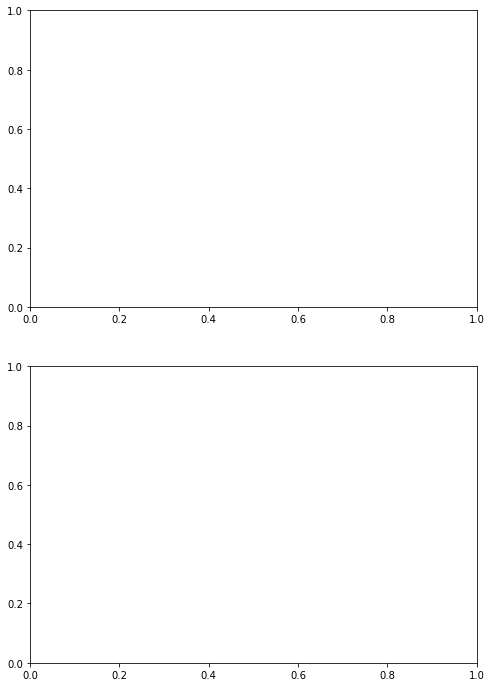

In [ ]:
fig, ax = plt.subplots(2,1,figsize=(8, 12))

In [ ]:
ax[0] = get_calibration_curve(ts_results_model_probability, ts_results_fraction_positive, 10, 0.4, ax[0])

In [ ]:
ax[1] = get_calibration_curve(two_results_model_probability, two_results_fraction_positive, 10, 0.4, ax[1])

In [ ]:
ax[0].text(-0.08, 1.02, 'A', transform=ax[0].transAxes, fontweight="bold", va="bottom", ha="left", fontsize=14)
ax[1].text(-0.08, 1.02, 'B', transform=ax[1].transAxes, fontweight="bold", va="bottom", ha="left", fontsize=14)

Text(-0.08, 1.02, 'B')

In [ ]:
ax[0].legend(loc='upper left', bbox_to_anchor=(0.9, 1.1))

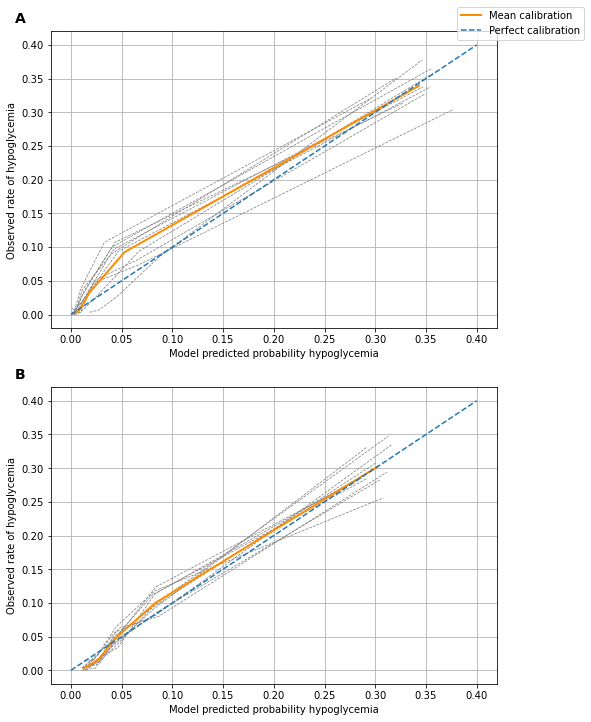

In [ ]:
fig

In [65]:
fig.savefig('../../results/figs/suppl_fig_calibration_curves.pdf', bbox_inches='tight')

## Closed loop

In [32]:
closed_loop = df[df['insulin_modality']=='closed_loop']
not_closed_loop = df[df['insulin_modality']!='closed_loop']

In [33]:
all_results= all_results+ calibrate_heatmap(closed_loop, 'closed_loop')
all_results= all_results+ calibrate_heatmap(not_closed_loop, 'not_closed_loop')

In [34]:
results_model_probability, results_fraction_positive = assess_calibration(closed_loop, 'y', 'probas_lr_two', 'probas_lr_two_fold')
fig = get_calibration_curve(results_model_probability, results_fraction_positive, 10, 0.3)

KeyError: 'probas_lr_two_fold'

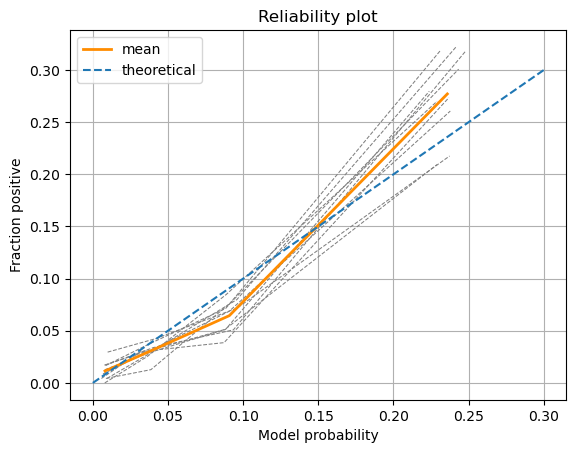

In [ ]:
results_model_probability, results_fraction_positive = assess_calibration(not_closed_loop, 'y', 'probas_lr_two', 'probas_lr_two_fold')
fig = get_calibration_curve(results_model_probability, results_fraction_positive, 10, 0.3)

## Study

In [ ]:
dexip = df[df['study']=='dexip']
not_dexip = df[df['study']!='dexip']

In [ ]:
all_results= all_results+ calibrate_heatmap(dexip, 'dexip')
all_results= all_results+ calibrate_heatmap(not_dexip, 'not_dexip')

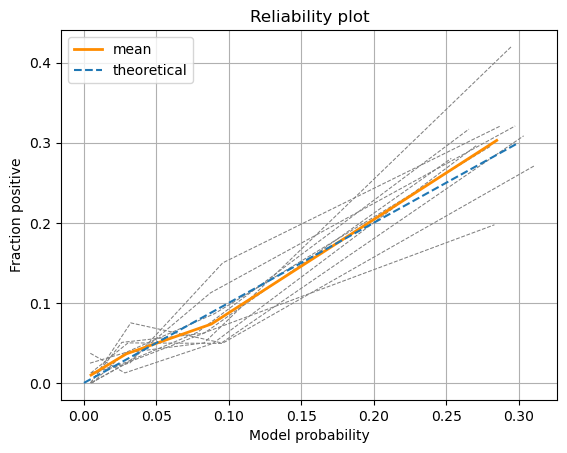

In [ ]:
results_model_probability, results_fraction_positive = assess_calibration(dexip, 'y_3', 'probas_lr_two', 'probas_lr_two_fold')
fig = get_calibration_curve(results_model_probability, results_fraction_positive, 10, 0.3)

## Sex

In [ ]:
male = df[df['sex']=='male']
female = df[df['sex']=='female']

In [ ]:
all_results = all_results+ calibrate_heatmap(male, 'male')
all_results= all_results+ calibrate_heatmap(female, 'female')

## Study

In [ ]:
ext_101 = df[df['study']=='ext_101']
ext_edu = df[df['study']=='ext_edu']
helm = df[df['study']=='helm']

In [ ]:
all_results = all_results+ calibrate_heatmap(ext_101, 'ext_101')
all_results = all_results+ calibrate_heatmap(ext_edu, 'ext_edu')
all_results= all_results+ calibrate_heatmap(helm, 'helm')

In [ ]:
subgroup_results = pd.DataFrame(all_results, columns=['subgroup', 'green', 'amber', 'red'])

In [ ]:
subgroup_results = subgroup_results.melt(id_vars=['subgroup'])

In [ ]:
subgroup_results

,subgroup,variable,value
0,all,green,0.012937
1,all,green,0.024907
2,all,green,0.026667
3,all,green,0.013298
4,all,green,0.021223
...,...,...,...
295,female,red,0.427273
296,female,red,0.380952
297,female,red,0.336000
298,female,red,0.390625


<AxesSubplot:xlabel='variable', ylabel='value'>

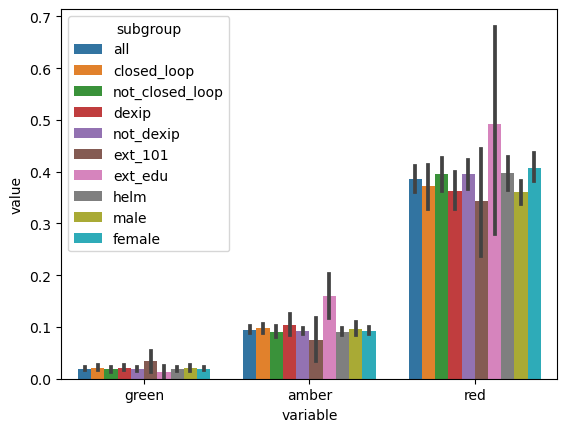

In [ ]:
sns.barplot(subgroup_results, x='variable', y='value', hue='subgroup')

In [ ]:
results_model_probability

,0,1,2,3
0,0.006211,0.029817,0.080555,0.221977
1,0.008556,0.032411,0.073697,0.201409
2,0.009001,0.038047,0.085488,0.220317
3,0.009030,0.037042,0.084175,0.211101
4,0.007342,0.032672,0.080816,0.209778
5,0.007113,0.031707,0.079675,0.225383
6,0.008131,0.034550,0.080914,0.210262
7,0.009758,0.036669,0.083789,0.219672
8,0.005958,0.029240,0.078248,0.212635
9,0.009075,0.036420,0.082781,0.207757


In [ ]:
results_model_probability[results_model_probability<0.05]

,0,1,2,3
0,0.006211,0.029817,NaN,NaN
1,0.008556,0.032411,NaN,NaN
2,0.009001,0.038047,NaN,NaN
3,0.009030,0.037042,NaN,NaN
4,0.007342,0.032672,NaN,NaN
5,0.007113,0.031707,NaN,NaN
6,0.008131,0.034550,NaN,NaN
7,0.009758,0.036669,NaN,NaN
8,0.005958,0.029240,NaN,NaN
9,0.009075,0.036420,NaN,NaN


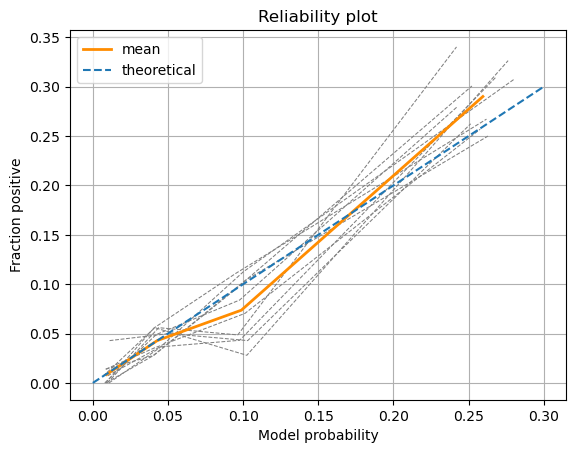

In [ ]:
results_model_probability, results_fraction_positive = assess_calibration(male, 'y_3', 'probas_lr_two', 'probas_lr_two_fold')
fig = get_calibration_curve(results_model_probability, results_fraction_positive, 10, 0.3)

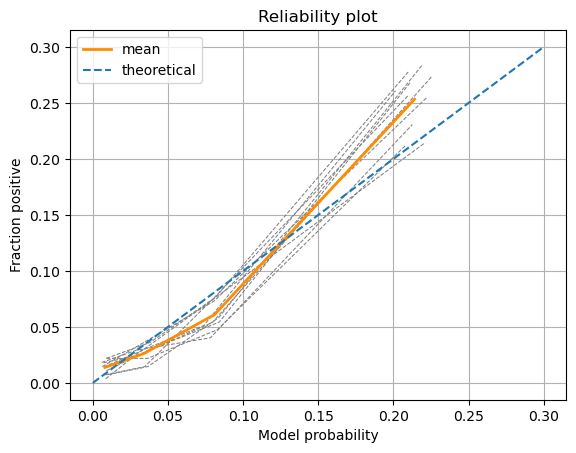

In [ ]:
results_model_probability, results_fraction_positive = assess_calibration(female, 'y_3', 'probas_lr_two', 'probas_lr_two_fold')
fig = get_calibration_curve(results_model_probability, results_fraction_positive, 10, 0.3)

## Logistic regression - Simple model

In [ ]:
results_fraction_positive

,0,1,2
0,0.012567,0.053860,0.225806
1,0.005396,0.041219,0.229391
2,0.017986,0.062837,0.189624
3,0.010791,0.046679,0.228980
4,0.012567,0.055755,0.229391
5,0.023381,0.043011,0.219031
6,0.005386,0.050269,0.236984
7,0.007181,0.044883,0.242370
8,0.016158,0.052065,0.201077
9,0.021544,0.037702,0.192101


In [ ]:
results_fraction_positive

In [ ]:
results_model_probability

,0,1,2,3,4
0,0.005022,0.023130,0.055130,0.109099,0.246742
1,0.007209,0.026645,0.054896,0.100891,0.227762
2,0.007919,0.030588,0.061933,0.112006,0.246712
3,0.007720,0.030348,0.060606,0.107793,0.236521
4,0.006606,0.027079,0.060026,0.106797,0.235650
5,0.006917,0.028313,0.060070,0.108172,0.245767
6,0.007929,0.028462,0.059441,0.108031,0.241652
7,0.008499,0.030009,0.060308,0.104833,0.234131
8,0.005483,0.022984,0.053756,0.101907,0.233865
9,0.007864,0.030008,0.061342,0.109211,0.234622


In [ ]:
results_model_probability, results_fraction_positive = assess_calibration(lr_results['observed'], lr_results['probas'], 10)

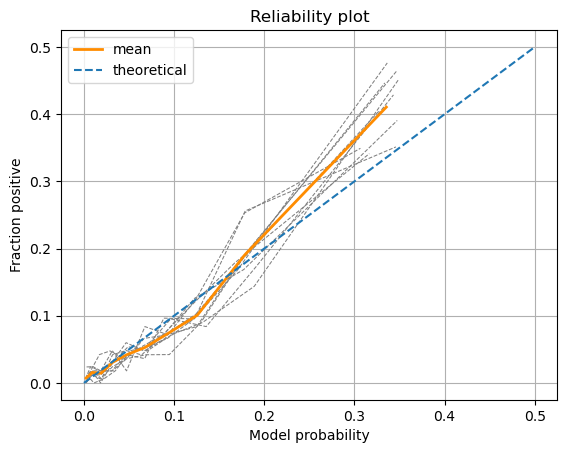

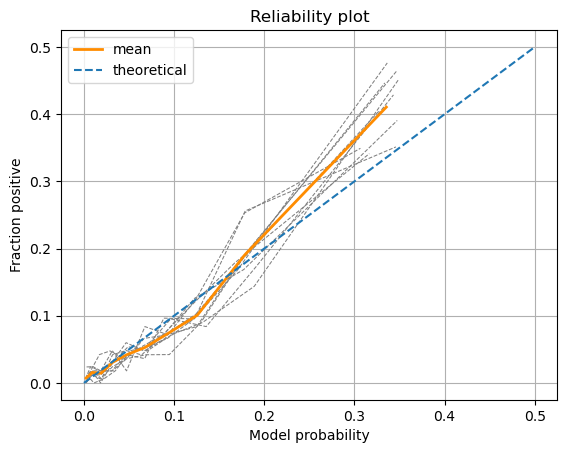

In [ ]:
get_calibration_curve(results_model_probability, results_fraction_positive, 10)

In [ ]:
X = df[['start_glc','duration']]
y = df['y']
model = LogisticRegression(C=0.06662641355374649, solver='liblinear')

### Without SMOTE

In [ ]:
results_model_probability_simple_model, results_fraction_positive_simple_model = assess_calibration(X, y, model, number_of_splits, False)

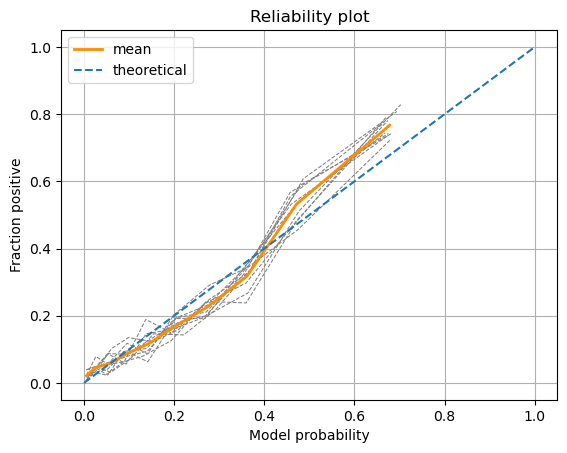

In [ ]:
fig = get_calibration_curve(results_model_probability_simple_model, results_fraction_positive_simple_model, number_of_splits)

### With SMOTE

In [ ]:
results_model_probability_simple_model_smote, results_fraction_positive_simple_model_smote = assess_calibration(X, y, model, number_of_splits, True)

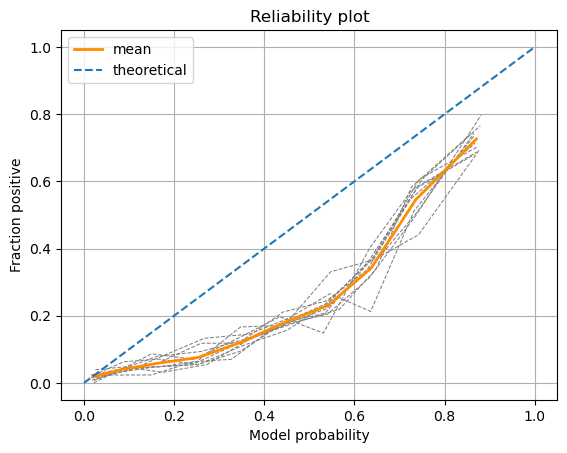

In [ ]:
fig = get_calibration_curve(results_model_probability_simple_model_smote, results_fraction_positive_simple_model_smote, number_of_splits)

## XGBoost advanced model

In [ ]:
X = pd.get_dummies(X)
imputer = KNNImputer(n_neighbors=5)
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

### Without SMOTE

In [ ]:
%%capture

results_model_probability_complex_model, results_fraction_positive_complex_model = assess_calibration(X, y, XGBClassifier(), number_of_splits, False)

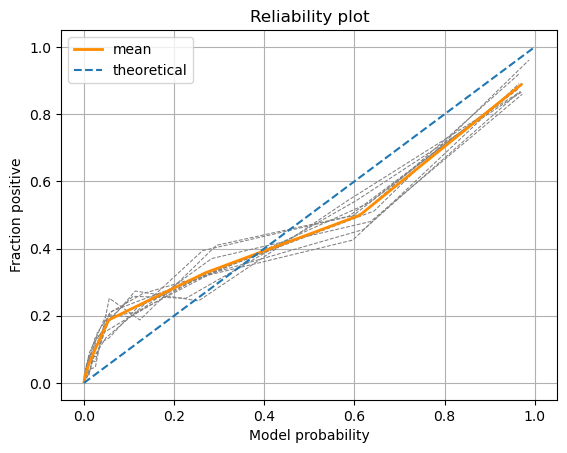

In [ ]:
fig = get_calibration_curve(results_model_probability_complex_model, results_fraction_positive_complex_model, number_of_splits)

### With SMOTE

In [ ]:
%%capture

results_model_probability_complex_model_smote, results_fraction_positive_complex_model_smote = assess_calibration(X, y, XGBClassifier(), number_of_splits, True)

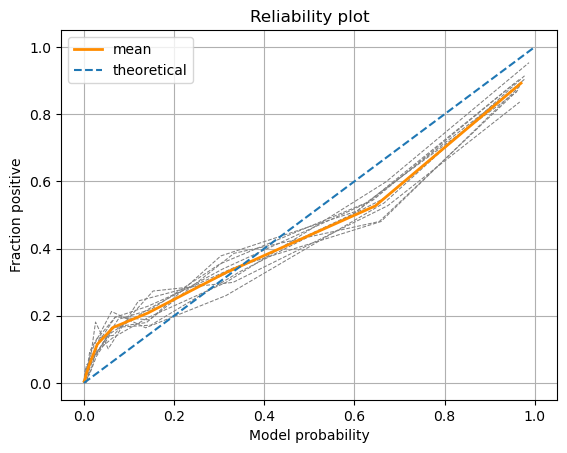

In [ ]:
fig = get_calibration_curve(results_model_probability_complex_model_smote, results_fraction_positive_complex_model_smote, number_of_splits)